# Example 2: 2D Doughnuts

In this example we'll take a toy 2D PDF (two rings, with density decreasing with distance from ring) and draw samples from it.

## Python preamble

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Matplotlib style file

In [2]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [3]:
rng = np.random.default_rng(42)

## Toy model

We'll define a function that evaluates the PDF. The PDF will look like two rings, one centred at $(-2, -2)$ and the other at $(2, 2)$, both with unit radius. Density drops as $e^{-d^2}$ with distance $d$ from the ring. The implementation here is a little hacky, but functional. The function takes in an array of coordinates shaped (N, 2) and returns an array of densities shaped (N).

It's worth noting that the PDF evaluated here is actually not a true PDF, in the sense that we have chucked away any normalising constants. This turns out not to matter, we'll still get samples OK.

In [4]:
def circles_pdf(x):
    c1 = np.array([-2.0, -2.0])
    r1 = 1.0
    c2 = np.array([2.0, 2.0])
    r2 = 1.0
    w = 0.4
    
    v1 = x - c1
    v2 = x - c2
    av1 = np.linalg.norm(v1, axis=-1)[:, None]
    av2 = np.linalg.norm(v2, axis=-1)[:, None]
    
    pt1 = np.zeros_like(x)
    pt2 = np.zeros_like(x)
    
    m1 = (av1 == 0).squeeze()
    m2 = (av2 == 0).squeeze()
    pt1[~m1] = c1 + r1 * v1[~m1] / av1[~m1]
    pt2[~m2] = c2 + r2 * v2[~m2] / av2[~m2]
    pt1[m1] = c1 + r1 * np.array([1.0, 0.0])
    pt2[m2] = c2 + r2 * np.array([1.0, 0.0])
    
    d1 = np.linalg.norm(x - pt1, axis=-1)
    d2 = np.linalg.norm(x - pt2, axis=-1)
    
    return np.exp(-0.5 * d1**2 / w**2) + np.exp(-0.5 * d2**2 / w**2)

Let's visualise this PDF:

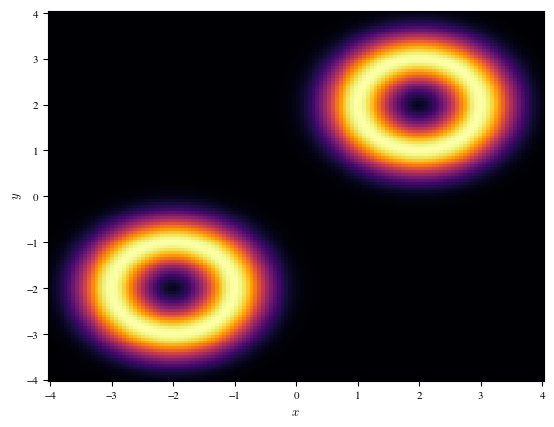

In [5]:
N_grid = 128
Xgrid, Ygrid = np.meshgrid(np.linspace(-4, 4, N_grid), np.linspace(-4, 4, N_grid), indexing='ij')
pos = np.stack((Xgrid, Ygrid), axis=-1).reshape((N_grid**2, 2))
plt.pcolormesh(Xgrid, Ygrid, circles_pdf(pos).reshape((N_grid, N_grid)), cmap='inferno')
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);

## `gridsample`

First, let's use `gridsample` to draw samples from the PDF evaluated on a fixed $16\times 16$ grid (recall that the grid needn't be fixed, it can have unequal spacings) between $x=-4$ and $x=4$. First, import `gridsample`:

In [6]:
from lintsampler import gridsample

ImportError: cannot import name 'gridsample' from 'lintsampler' (unknown location)

Set up grid and evaluate PDF:

In [ ]:
N_grid = 16
edges = np.linspace(-4, 4, N_grid + 1)
edgegrid = np.stack(np.meshgrid(edges, edges, indexing='ij'), axis=-1).reshape(((N_grid+1)**2, 2))
f = circles_pdf(edgegrid).reshape((N_grid + 1, N_grid + 1))

Draw samples:

In [ ]:
X = gridsample(edges, edges, f=f, N_samples=10000000, seed=rng)

Visualise:

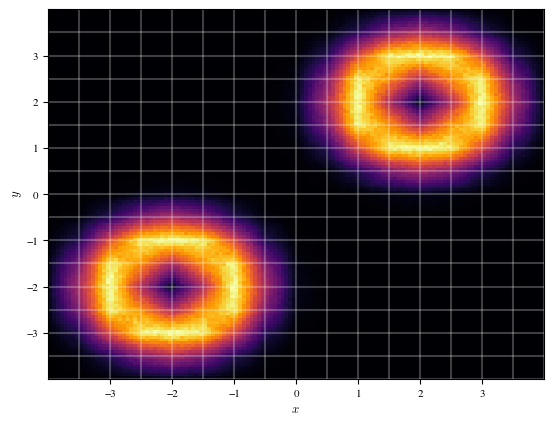

In [ ]:
plt.hist2d(X[:, 0], X[:, 1], 128, cmap='inferno');
for edge in edges:
    plt.plot([edge, edge], [-4, 4], c='w', alpha=0.25)
    plt.plot([-4, 4], [edge, edge], c='w', alpha=0.25)
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);

Seems to work well, but there are clear grid artifacts.

## `sample`

Using a space-filling grid with `gridsample` is wasteful in situations like this one, where a lot of space has no mass (e.g., the top left and bottom right). Here we could instead have two $12 \times 12$ grids, one for each ring. First, import `sample`:

In [ ]:
from lintsampler import sample

Set up two grids and evaluate densities on grids.

In [ ]:
N_grid = 12
e0 = np.linspace(-4, 0, N_grid + 1)
g0 = np.stack(np.meshgrid(e0, e0, indexing='ij'), axis=-1).reshape(((N_grid + 1)**2, 2))
e1 = np.linspace(0, 4, N_grid + 1)
g1 = np.stack(np.meshgrid(e1, e1, indexing='ij'), axis=-1).reshape(((N_grid + 1)**2, 2))
f0 = circles_pdf(g0).reshape((N_grid + 1, N_grid + 1))
f1 = circles_pdf(g0).reshape((N_grid + 1, N_grid + 1))

Some slightly ugly business to get all the arrays in the right forms (`x0` and `x1` both 2D numpy arrays, shape $288\times 2$, and separate 1D arrays (length 288) for each corner density).

In [ ]:

x0 = np.vstack([g0.reshape((N_grid + 1, N_grid + 1, 2))[:-1, :-1].reshape((N_grid**2, 2)), g1.reshape((N_grid + 1, N_grid + 1, 2))[:-1, :-1].reshape((N_grid**2, 2))])
x1 = np.vstack([g0.reshape((N_grid + 1, N_grid + 1, 2))[1:, 1:].reshape((N_grid**2, 2)), g1.reshape((N_grid + 1, N_grid + 1, 2))[1:, 1:].reshape((N_grid**2, 2))])
f00 = np.hstack([f0[:-1, :-1].flatten(), f1[:-1, :-1].flatten()])
f01 = np.hstack([f0[:-1, 1:].flatten(), f1[:-1, 1:].flatten()])
f10 = np.hstack([f0[1:, :-1].flatten(), f1[1:, :-1].flatten()])
f11 = np.hstack([f0[1:, 1:].flatten(), f1[1:, 1:].flatten()])

Draw samples:

In [ ]:
samples = sample(x0, x1, f00, f01, f10, f11, N_samples=10000000, seed=rng)

Visualise:

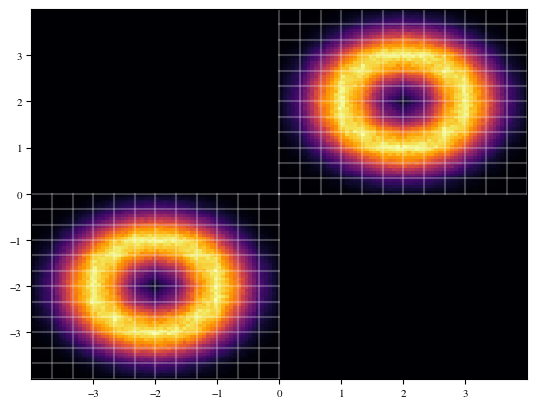

In [ ]:
plt.hist2d(samples[:, 0], samples[:, 1], 128, cmap='inferno');
for edge in e0:
    plt.plot([edge, edge], [-4, 0], c='w', alpha=0.25)
    plt.plot([-4, 0], [edge, edge], c='w', alpha=0.25)
for edge in e1:
    plt.plot([edge, edge], [0, 4], c='w', alpha=0.25)
    plt.plot([0, 4], [edge, edge], c='w', alpha=0.25)

## Final checks

As in example 1, let's check that we can completely remove grid artifacts if we dial up the grid resolution.

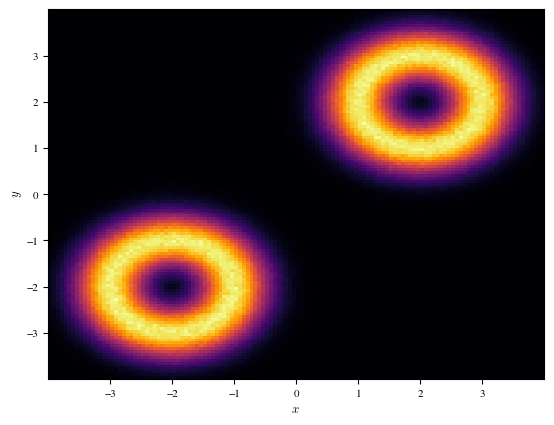

In [ ]:
N_grid = 256
edges = np.linspace(-4, 4, N_grid + 1)
edgegrid = np.stack(np.meshgrid(edges, edges, indexing='ij'), axis=-1).reshape(((N_grid+1)**2, 2))
f = circles_pdf(edgegrid).reshape((N_grid + 1, N_grid + 1))

X = gridsample(edges, edges, f=f, N_samples=10000000, seed=rng)

plt.hist2d(X[:, 0], X[:, 1], 128, cmap='inferno');
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);